In [ ]:
####
## Title: Postal Rollout Analysis
## Date Created: 9/24/2025
## Description: Analyze Postal Rollout Data
## Requirements: 
#####

In [16]:
############################
## Setting Up Environment ##
############################
import pandas as pd 
import numpy as np
import re
from linearmodels import PanelOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [17]:
##################
## Loading Data ##
##################
## Loading postal panel data 
postal_panel_dat = pd.read_csv('../data/cleaned/postal_rollout_panel.csv')
print(postal_panel_dat.columns)


Index(['Town', 'Rollout_Date', 'State', 'Rollout_Year', 'N_expand_row',
       'year_index', 'Year', 'N_patients', 'has_patient'],
      dtype='object')


In [18]:
###################
## Data Cleaning ##
###################
## Creating Variables of Analysis
postal_panel_dat['town_state']        = postal_panel_dat['Town']+postal_panel_dat['State']
postal_panel_dat['years_since_shift'] = postal_panel_dat['Year'] - postal_panel_dat['Rollout_Year'] 



In [24]:
#########################
## Regression Analysis ##
#########################
## Defining what our LHS and RHS variables
LHS_vars = [] 
RHS_vars  = ['has_patient']

## Creating Indicator Variables
reg_min_frame = -3
reg_max_frame = 4
reg_dat = postal_panel_dat.loc[(postal_panel_dat['years_since_shift'] >= reg_min_frame) & (postal_panel_dat['years_since_shift'] <= reg_max_frame)].reset_index(drop=True)
for k in range(reg_min_frame, reg_max_frame + 1):
    if k < 0: 
        col_name = f'change_tm{abs(k)}'
    elif k > 0:
        col_name = f'change_tp{k}'
    else:
        col_name = 'change_tp0'
    ## Adding variables to the LHS of regression 
    if k != -1:
        LHS_vars.append(col_name)

    ## Creating the Variable
    reg_dat[col_name] = (reg_dat['years_since_shift'] == k).astype(int) 


## Set index
reg_dat = reg_dat.set_index(['town_state','Year'])

# LHS = has_patient, RHS = list of dummies
Y = reg_dat['has_patient']
# X = reg_dat[['change_tm10', 'change_tm9', 'change_tm8', 'change_tm7', 'change_tm6', 'change_tm5', 'change_tm4', 'change_tm3', 'change_tm1', 
#              'change_tp0', 'change_tp1', 'change_tp2', 'change_tp3', 'change_tp4', 'change_tp5', 'change_tp6', 'change_tp7', 'change_tp8', 'change_tp9' , 'change_tp10' ]]
# X = reg_dat[LHS_vars]

X = reg_dat[['change_tm3', 
             'change_tp0', 'change_tp1', 'change_tp2', 'change_tp3', 'change_tp4' ]]

# # Add constant (optional, sometimes collinear with FE so you can drop it)
X = sm.add_constant(X)

# Run two-way fixed effects regression
model = PanelOLS(
    Y, X,
    entity_effects=True,   # town_state FE
    time_effects=True      # Year FE
)

results = model.fit(cov_type="clustered", cluster_entity=True)  
print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:            has_patient   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):            2.22e-16
No. Observations:               98544   R-squared (Within):               0.0018
Date:                Wed, Sep 24 2025   R-squared (Overall):              0.0009
Time:                        18:48:20   Log-likelihood                -1.291e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.3610
Entities:                       12318   P-value                           0.0026
Avg Obs:                       8.0000   Distribution:                 F(6,86205)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             2.7215
                            

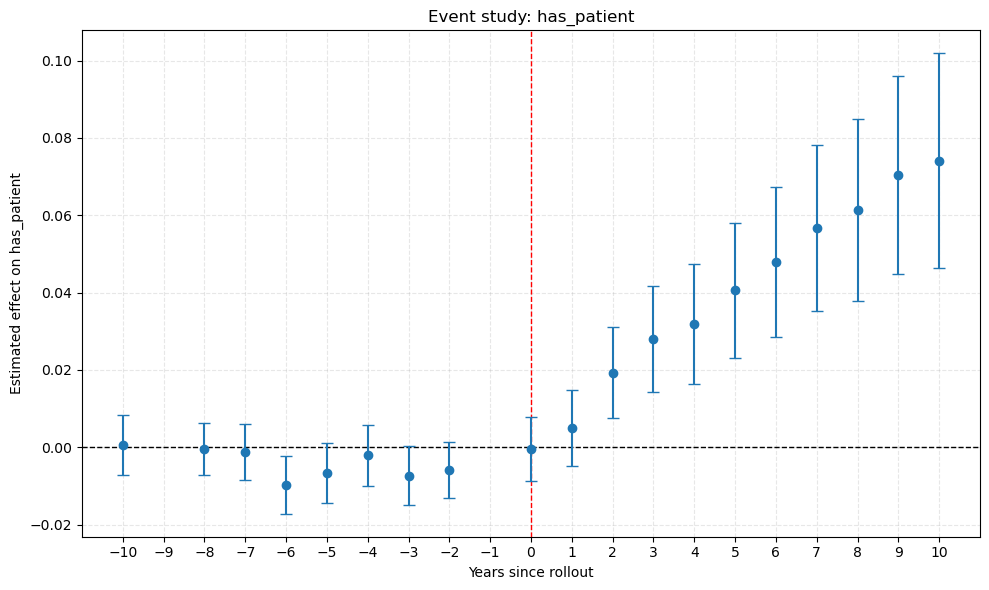


Some variables were not plotted (missing or dropped):
 - const: could not parse name


In [10]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# coef and conf_int from the fitted model
coef = results.params
conf_int = results.conf_int()

# find the lower/upper column names in conf_int (robust to column labels)
lower_col, upper_col = conf_int.columns[0], conf_int.columns[1]

# Use the X columns you actually supplied to the model (keeps order)
vars_to_plot = X.columns.tolist()

plot_rows = []
missing_vars = []

# helper to parse variable name into integer event time
def parse_event_time(varname):
    m = re.match(r'^change_tm(\d+)$', varname)
    if m:
        return -int(m.group(1))
    m = re.match(r'^change_tp(\d+)$', varname)
    if m:
        return int(m.group(1))
    # allow neutral name variants
    if varname in ('change_t0', 'change_tp0', 'change_t_0'):
        return 0
    return None

for var in vars_to_plot:
    t = parse_event_time(var)
    if t is None:
        missing_vars.append((var, 'could not parse name'))
        continue

    if var not in coef.index:
        missing_vars.append((var, 'not in results.params'))
        continue
    if var not in conf_int.index:
        missing_vars.append((var, 'not in results.conf_int()'))
        continue

    coef_val = float(coef.loc[var])
    ci_low = float(conf_int.loc[var, lower_col])
    ci_high = float(conf_int.loc[var, upper_col])

    plot_rows.append({'time': t, 'coef': coef_val, 'ci_low': ci_low, 'ci_high': ci_high})

plot_df = pd.DataFrame(plot_rows)

if plot_df.empty:
    print("No coefficients found to plot. Variables checked and why they were missing:")
    for v, reason in missing_vars:
        print(f" - {v}: {reason}")
else:
    # sort by event time
    plot_df = plot_df.sort_values('time')

    # plot
    plt.figure(figsize=(10,6))
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='red', linestyle='--', linewidth=1)

    yerr = [
        plot_df['coef'] - plot_df['ci_low'],
        plot_df['ci_high'] - plot_df['coef']
    ]

    plt.errorbar(plot_df['time'], plot_df['coef'],
                 yerr=yerr, fmt='o', capsize=4, markersize=6, label='Estimate (95% CI)')
    plt.scatter(plot_df['time'], plot_df['coef'], s=20)

    plt.xticks(range(int(plot_df['time'].min()), int(plot_df['time'].max()) + 1))
    plt.xlabel('Years since rollout')
    plt.ylabel('Estimated effect on has_patient')
    plt.title('Event study: has_patient')
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    if missing_vars:
        print("\nSome variables were not plotted (missing or dropped):")
        for v, reason in missing_vars:
            print(f" - {v}: {reason}")
